<h1> Assignment 7 Naman Kedia
    </h1>

In [1]:
import nltk
import json
import os
import re
import pandas as pd
import numpy as np
from glob import glob
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# import nltk

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/namankedia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/namankedia/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/namankedia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
all_data = pd.read_csv('MSF_1996_2023.csv', low_memory=False)
all_data['date'] = pd.to_datetime(all_data['date'])
all_data = all_data.sort_values(['date', 'PERMNO'])

In [4]:
def map_industry(siccd):
    if 1 <= siccd <= 999:
        return "Agriculture, Forestry and Fishing"
    elif 1000 <= siccd <= 1499:
        return "Mining"
    elif 1500 <= siccd <= 1799:
        return "Construction"
    elif 2000 <= siccd <= 3999:
        return "Manufacturing"
    elif 4000 <= siccd <= 4999:
        return "Transportation and other Utilities"
    elif 5000 <= siccd <= 5199:
        return "Wholesale Trade"
    elif 5200 <= siccd <= 5999:
        return "Retail Trade"
    elif 6000 <= siccd <= 6799:
        return "Finance, Insurance and Real Estate"
    elif 7000 <= siccd <= 8999:
        return "Services"
    else:
        return "Public Administration"

def map_industry_code(siccd):
    if 1 <= siccd <= 999:
        return 10
    elif 1000 <= siccd <= 1499:
        return 1
    elif 1500 <= siccd <= 1799:
        return 2
    elif 2000 <= siccd <= 3999:
        return 3
    elif 4000 <= siccd <= 4999:
        return 4
    elif 5000 <= siccd <= 5199:
        return 5
    elif 5200 <= siccd <= 5999:
        return 6
    elif 6000 <= siccd <= 6799:
        return 7
    elif 7000 <= siccd <= 8999:
        return 8
    else:
        return 9

industry_labels = [
    "Agriculture, Forestry and Fishing",
    "Mining",
    "Construction",
    "Manufacturing",
    "Transportation and other Utilities",
    "Wholesale Trade",
    "Retail Trade",
    "Finance, Insurance and Real Estate",
    "Services",
    "Public Administration"
]

<h1> Creating the MSF Data
    </h1>

In [5]:
all_data['SICCDINT'] = pd.to_numeric(all_data['SICCD'], errors='coerce')
all_data = all_data.dropna(subset=['SICCDINT'])
all_data['industry'] = all_data['SICCDINT'].apply(map_industry)
all_data['RET'] = pd.to_numeric(all_data['RET'], errors='coerce')
all_data['vwretd'] = pd.to_numeric(all_data['vwretd'], errors='coerce')
all_data = all_data.dropna(subset=['RET', 'vwretd'])
msf_data = all_data.copy(deep=True)

In [6]:
def create_relevant_df(full_data, sample_firms):
    sample_permnos = sample_firms
    full_data = full_data.sort_values(['PERMNO', 'date'])
    data_for_beta = full_data[full_data['PERMNO'].isin(sample_permnos)]
    data_for_beta['beta'] = data_for_beta['RET']/data_for_beta['vwretd']
    data_for_beta['industry_code'] = data_for_beta['SICCDINT'].apply(map_industry_code)
    return data_for_beta.copy(deep=True)

def compute_market_cap_percentage(df):
    df['MarketCap'] = df['PRC'] * df['SHROUT']
    total_market_cap = df.groupby('date')['MarketCap'].transform('sum')
    df['MarketCapWeight'] = df['MarketCap'] / total_market_cap

In [7]:
def sample_unique_companies(group):
    unique_companies = group.drop_duplicates(subset='PERMNO')
    if len(unique_companies) > 10:
        return unique_companies.sample(10)
    else:
        return unique_companies

def select_sample(df, year):
    year_data = df[df['date'].dt.year == year]
    return year_data.groupby('industry').apply(sample_unique_companies).reset_index(drop=True)

In [8]:
compute_market_cap_percentage(msf_data)
msf_data['Year'] = msf_data['date'].dt.year

<h1> 10K Filings Tokennization and PreProcessing
    </h1>

In [9]:
def tokenize_text(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
        text = data['item_1A']
        permno = data['PERMNO']
        filing_date = pd.to_datetime(data['filing_date'])
        year = filing_date.year
        sentences = nltk.sent_tokenize(text)
    return sentences, filing_date, data['PERMNO'], year

In [10]:
keywords = {
    'attack': {'relevant': ['cyber-', 'cyber', 'networks', 'systems', 'products', 'services', 'datacenter', 'infrastructure'],
               'irrelevant': ['terror', 'war', 'contraband', 'bombs']},
    'threat': {'relevant': ['cyber-', 'cyber', 'networks', 'systems', 'products', 'services', 'datacenter', 'infrastructure'],
               'irrelevant': ['terror', 'simulator', 'disease', 'legal action', 'competitors']},
    'computer': {'relevant': ['malware', 'virus', 'viruses', 'intrusions'],
                 'irrelevant': ['fires', 'product sales', 'warranty claim']},
    'information system': {'relevant': ['malware', 'virus', 'viruses', 'intrusions'],
                           'irrelevant': ['fires', 'product sales', 'warranty claim']},
    'malicious': {'relevant': ['software', 'programs', 'third parties', 'attacks'],
                  'irrelevant': []},
    'breaches': {'relevant': [],
                 'irrelevant': ['fiduciary duty', 'fiduciary duties', 'covenant', 'credit', 'agreement']},
    'hacker': {'relevant': ['*'], 
               'irrelevant': ['fiduciary', 'warranty', 'regulations', 'contract']},
    'hacking': {'relevant': ['*'], 
                'irrelevant': ['fiduciary', 'warranty', 'regulations', 'contract']},
    'social engineering': {'relevant': ['*'], 
                          'irrelevant': ['fiduciary', 'warranty', 'regulations', 'contract']},
    'denial of service': {'relevant': ['*'], 
                          'irrelevant': ['fiduciary', 'warranty', 'regulations', 'contract']},
    'cyberattack': {'relevant': ['*'], 
                    'irrelevant': ['fiduciary', 'warranty', 'regulations', 'contract']},
    'cybersecurity': {'relevant': ['*'], 
                      'irrelevant': ['fiduciary',  'warranty', 'regulations','contract']}
}

In [12]:
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')

stemmer = EnglishStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def process_variation_for_text(text):
    words = text.split()
    return ' '.join([stemmer.stem(lemmatizer.lemmatize(word)) for word in words if word.isalnum() and word not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/namankedia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/namankedia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
def is_relevant_sentence(sentence):
    sentence = process_variation_for_text(sentence.lower())
    for keyword, conditions in keywords.items():
        keyword = process_variation_for_text(keyword)
        if keyword in sentence:
            if '*' in conditions['relevant']:
                for irrelevant in conditions['irrelevant']:
                    if irrelevant in sentence:
                        return False
                return True
            else:
                for relevant in conditions['relevant']:
                    if relevant in sentence:
                        return True
                for irrelevant in conditions['irrelevant']:
                    if irrelevant in sentence:
                        return False
    return False

In [14]:
def extract_relevant_sentences(sentences):
    return [sentence for sentence in sentences if is_relevant_sentence(sentence)]

<h1> Reading of the Data and and calculation of the absolute risk and risk ratio
    </h1>

In [19]:
def calculate_cybersecurity_risk(relevant_sentences, total_sentences):
    if len(total_sentences)==0:
        return 0
    return len(relevant_sentences) / len(total_sentences), len(relevant_sentences) 

def process_files(directory):
    results = []
    count=0
    for file_path in glob(os.path.join(directory, '*.json')):
        if(count%3==1 or count%3==2):
            count=count+1
            continue
        sentences, filing_date, permno, year = tokenize_text(file_path)
        if(sentences == None):
            continue
        relevant_sentences = extract_relevant_sentences(sentences)
        risk_measure, risk_abs = calculate_cybersecurity_risk(relevant_sentences, sentences)
#         risk_measure = 0
        results.append({'PERMNO': permno, 'filing_date': filing_date, 'year': year, 'cybersecurity_risk_ratio': risk_measure,'cybersecurity_risk_abs': risk_abs, 'sentences': sentences, 'relevant_sentences': relevant_sentences})
        count=count+1
        print(count)
#         if(count==len(sample_firms)):
#             break
    return pd.DataFrame(results)

In [20]:
# %%timeit -r 1 -n 1
cybersecurity_df = process_files('10K_item1a_PERMNO')

cybersecurity_df['year'] = pd.to_datetime(cybersecurity_df['filing_date']).dt.year



1
4
7
10
13
16
19
22
25
28
31
34
37
40
43
46
49
52
55
58
61
64
67
70
73
76
79
82
85
88
91
94
97
100
103
106
109
112
115
118
121
124
127
130
133
136
139
142
145
148
151
154
157
160
163
166
169
172
175
178
181
184
187
190
193
196
199
202
205
208
211
214
217
220
223
226
229
232
235
238
241
244
247
250
253
256
259
262
265
268
271
274
277
280
283
286
289
292
295
298
301
304
307
310
313
316
319
322
325
328
331
334
337
340
343
346
349
352
355
358
361
364
367
370
373
376
379
382
385
388
391
394
397
400
403
406
409
412
415
418
421
424
427
430
433
436
439
442
445
448
451
454
457
460
463
466
469
472
475
478
481
484
487
490
493
496
499
502
505
508
511
514
517
520
523
526
529
532
535
538
541
544
547
550
553
556
559
562
565
568
571
574
577
580
583
586
589
592
595
598
601
604
607
610
613
616
619
622
625
628
631
634
637
640
643
646
649
652
655
658
661
664
667
670
673
676
679
682
685
688
691
694
697
700
703
706
709
712
715
718
721
724
727
730
733
736
739
742
745
748
751
754
757
760
763
766
769
772
775


5143
5146
5149
5152
5155
5158
5161
5164
5167
5170
5173
5176
5179
5182
5185
5188
5191
5194
5197
5200
5203
5206
5209
5212
5215
5218
5221
5224
5227
5230
5233
5236
5239
5242
5245
5248
5251
5254
5257
5260
5263
5266
5269
5272
5275
5278
5281
5284
5287
5290
5293
5296
5299
5302
5305
5308
5311
5314
5317
5320
5323
5326
5329
5332
5335
5338
5341
5344
5347
5350
5353
5356
5359
5362
5365
5368
5371
5374
5377
5380
5383
5386
5389
5392
5395
5398
5401
5404
5407
5410
5413
5416
5419
5422
5425
5428
5431
5434
5437
5440
5443
5446
5449
5452
5455
5458
5461
5464
5467
5470
5473
5476
5479
5482
5485
5488
5491
5494
5497
5500
5503
5506
5509
5512
5515
5518
5521
5524
5527
5530
5533
5536
5539
5542
5545
5548
5551
5554
5557
5560
5563
5566
5569
5572
5575
5578
5581
5584
5587
5590
5593
5596
5599
5602
5605
5608
5611
5614
5617
5620
5623
5626
5629
5632
5635
5638
5641
5644
5647
5650
5653
5656
5659
5662
5665
5668
5671
5674
5677
5680
5683
5686
5689
5692
5695
5698
5701
5704
5707
5710
5713
5716
5719
5722
5725
5728
5731
5734
5737
5740


10051
10054
10057
10060
10063
10066
10069
10072
10075
10078
10081
10084
10087
10090
10093
10096
10099
10102
10105
10108
10111
10114
10117
10120
10123
10126
10129
10132
10135
10138
10141
10144
10147
10150
10153
10156
10159
10162
10165
10168
10171
10174
10177
10180
10183
10186
10189
10192
10195
10198
10201
10204
10207
10210
10213
10216
10219
10222
10225
10228
10231
10234
10237
10240
10243
10246
10249
10252
10255
10258
10261
10264
10267
10270
10273
10276
10279
10282
10285
10288
10291
10294
10297
10300
10303
10306
10309
10312
10315
10318
10321
10324
10327
10330
10333
10336
10339
10342
10345
10348
10351
10354
10357
10360
10363
10366
10369
10372
10375
10378
10381
10384
10387
10390
10393
10396
10399
10402
10405
10408
10411
10414
10417
10420
10423
10426
10429
10432
10435
10438
10441
10444
10447
10450
10453
10456
10459
10462
10465
10468
10471
10474
10477
10480
10483
10486
10489
10492
10495
10498
10501
10504
10507
10510
10513
10516
10519
10522
10525
10528
10531
10534
10537
10540
10543
10546
1054

14149
14152
14155
14158
14161
14164
14167
14170
14173
14176
14179
14182
14185
14188
14191
14194
14197
14200
14203
14206
14209
14212
14215
14218
14221
14224
14227
14230
14233
14236
14239
14242
14245
14248
14251
14254
14257
14260
14263
14266
14269
14272
14275
14278
14281
14284
14287
14290
14293
14296
14299
14302
14305
14308
14311
14314
14317
14320
14323
14326
14329
14332
14335
14338
14341
14344
14347
14350
14353
14356
14359
14362
14365
14368
14371
14374
14377
14380
14383
14386
14389
14392
14395
14398
14401
14404
14407
14410
14413
14416
14419
14422
14425
14428
14431
14434
14437
14440
14443
14446
14449
14452
14455
14458
14461
14464
14467
14470
14473
14476
14479
14482
14485
14488
14491
14494
14497
14500
14503
14506
14509
14512
14515
14518
14521
14524
14527
14530
14533
14536
14539
14542
14545
14548
14551
14554
14557
14560
14563
14566
14569
14572
14575
14578
14581
14584
14587
14590
14593
14596
14599
14602
14605
14608
14611
14614
14617
14620
14623
14626
14629
14632
14635
14638
14641
14644
1464

18250
18253
18256
18259
18262
18265
18268
18271
18274
18277
18280
18283
18286
18289
18292
18295
18298
18301
18304
18307
18310
18313
18316
18319
18322
18325
18328
18331
18334
18337
18340
18343
18346
18349
18352
18355
18358
18361
18364
18367
18370
18373
18376
18379
18382
18385
18388
18391
18394
18397
18400
18403
18406
18409
18412
18415
18418
18421
18424
18427
18430
18433
18436
18439
18442
18445
18448
18451
18454
18457
18460
18463
18466
18469
18472
18475
18478
18481
18484
18487
18490
18493
18496
18499
18502
18505
18508
18511
18514
18517
18520
18523
18526
18529
18532
18535
18538
18541
18544
18547
18550
18553
18556
18559
18562
18565
18568
18571
18574
18577
18580
18583
18586
18589
18592
18595
18598
18601
18604
18607
18610
18613
18616
18619
18622
18625
18628
18631
18634
18637
18640
18643
18646
18649
18652
18655
18658
18661
18664
18667
18670
18673
18676
18679
18682
18685
18688
18691
18694
18697
18700
18703
18706
18709
18712
18715
18718
18721
18724
18727
18730
18733
18736
18739
18742
18745
1874

22348
22351
22354
22357
22360
22363
22366
22369
22372
22375
22378
22381
22384
22387
22390
22393
22396
22399
22402
22405
22408
22411
22414
22417
22420
22423
22426
22429
22432
22435
22438
22441
22444
22447
22450
22453
22456
22459
22462
22465
22468
22471
22474
22477
22480
22483
22486
22489
22492
22495
22498
22501
22504
22507
22510
22513
22516
22519
22522
22525
22528
22531
22534
22537
22540
22543
22546
22549
22552
22555
22558
22561
22564
22567
22570
22573
22576
22579
22582
22585
22588
22591
22594
22597
22600
22603
22606
22609
22612
22615
22618
22621
22624
22627
22630
22633
22636
22639
22642
22645
22648
22651
22654
22657
22660
22663
22666
22669
22672
22675
22678
22681
22684
22687
22690
22693
22696
22699
22702
22705
22708
22711
22714
22717
22720
22723
22726
22729
22732
22735
22738
22741
22744
22747
22750
22753
22756
22759
22762
22765
22768
22771
22774
22777
22780
22783
22786
22789
22792
22795
22798
22801
22804
22807
22810
22813
22816
22819
22822
22825
22828
22831
22834
22837
22840
22843
2284

26449
26452
26455
26458
26461
26464
26467
26470
26473
26476
26479
26482
26485
26488
26491
26494
26497
26500
26503
26506
26509
26512
26515
26518
26521
26524
26527
26530
26533
26536
26539
26542
26545
26548
26551
26554
26557
26560
26563
26566
26569
26572
26575
26578
26581
26584
26587
26590
26593
26596
26599
26602
26605
26608
26611
26614
26617
26620
26623
26626
26629
26632
26635
26638
26641
26644
26647
26650
26653
26656
26659
26662
26665
26668
26671
26674
26677
26680
26683
26686
26689
26692
26695
26698
26701
26704
26707
26710
26713
26716
26719
26722
26725
26728
26731
26734
26737
26740
26743
26746
26749
26752
26755
26758
26761
26764
26767
26770
26773
26776
26779
26782
26785
26788
26791
26794
26797
26800
26803
26806
26809
26812
26815
26818
26821
26824
26827
26830
26833
26836
26839
26842
26845
26848
26851
26854
26857
26860
26863
26866
26869
26872
26875
26878
26881
26884
26887
26890
26893
26896
26899
26902
26905
26908
26911
26914
26917
26920
26923
26926
26929
26932
26935
26938
26941
26944
2694

30547
30550
30553
30556
30559
30562
30565
30568
30571
30574
30577
30580
30583
30586
30589
30592
30595
30598
30601
30604
30607
30610
30613
30616
30619
30622
30625
30628
30631
30634
30637
30640
30643
30646
30649
30652
30655
30658
30661
30664
30667
30670
30673
30676
30679
30682
30685
30688
30691
30694
30697
30700
30703
30706
30709
30712
30715
30718
30721
30724
30727
30730
30733
30736
30739
30742
30745
30748
30751
30754
30757
30760
30763
30766
30769
30772
30775
30778
30781
30784
30787
30790
30793
30796
30799
30802
30805
30808
30811
30814
30817
30820
30823
30826
30829
30832
30835
30838
30841
30844
30847
30850
30853
30856
30859
30862
30865
30868
30871
30874
30877
30880
30883
30886
30889
30892
30895
30898
30901
30904
30907
30910
30913
30916
30919
30922
30925
30928
30931
30934
30937
30940
30943
30946
30949
30952
30955
30958
30961
30964
30967
30970
30973
30976
30979
30982
30985
30988
30991
30994
30997
31000
31003
31006
31009
31012
31015
31018
31021
31024
31027
31030
31033
31036
31039
31042
3104

34648
34651
34654
34657
34660
34663
34666
34669
34672
34675
34678
34681
34684
34687
34690
34693
34696
34699
34702
34705
34708
34711
34714
34717
34720
34723
34726
34729
34732
34735
34738
34741
34744
34747
34750
34753
34756
34759
34762
34765
34768
34771
34774
34777
34780
34783
34786
34789
34792
34795
34798
34801
34804
34807
34810
34813
34816
34819
34822
34825
34828
34831
34834
34837
34840
34843
34846
34849
34852
34855
34858
34861
34864
34867
34870
34873
34876
34879
34882
34885
34888
34891
34894
34897
34900
34903
34906
34909
34912
34915
34918
34921
34924
34927
34930
34933
34936
34939
34942
34945
34948
34951
34954
34957
34960
34963
34966
34969
34972
34975
34978
34981
34984
34987
34990
34993
34996
34999
35002
35005
35008
35011
35014
35017
35020
35023
35026
35029
35032
35035
35038
35041
35044
35047
35050
35053
35056
35059
35062
35065
35068
35071
35074
35077
35080
35083
35086
35089
35092
35095
35098
35101
35104
35107
35110
35113
35116
35119
35122
35125
35128
35131
35134
35137
35140
35143
3514

38746
38749
38752
38755
38758
38761
38764
38767
38770
38773
38776
38779
38782
38785
38788
38791
38794
38797
38800
38803
38806
38809
38812
38815
38818
38821
38824
38827
38830
38833
38836
38839
38842
38845
38848
38851
38854
38857
38860
38863
38866
38869
38872
38875
38878
38881
38884
38887
38890
38893
38896
38899
38902
38905
38908
38911
38914
38917
38920
38923
38926
38929
38932
38935
38938
38941
38944
38947
38950
38953
38956
38959
38962
38965
38968
38971
38974
38977
38980
38983
38986
38989
38992
38995
38998
39001
39004
39007
39010
39013
39016
39019
39022
39025
39028
39031
39034
39037
39040
39043
39046
39049
39052
39055
39058
39061
39064
39067
39070
39073
39076
39079
39082
39085
39088
39091
39094
39097
39100
39103
39106
39109
39112
39115
39118
39121
39124
39127
39130
39133
39136
39139
39142
39145
39148
39151
39154
39157
39160
39163
39166
39169
39172
39175
39178
39181
39184
39187
39190
39193
39196
39199
39202
39205
39208
39211
39214
39217
39220
39223
39226
39229
39232
39235
39238
39241
3924

42844
42847
42850
42853
42856
42859
42862
42865
42868
42871
42874
42877
42880
42883
42886
42889
42892
42895
42898
42901
42904
42907
42910
42913
42916
42919
42922
42925
42928
42931
42934
42937
42940
42943
42946
42949
42952
42955
42958
42961
42964
42967
42970
42973
42976
42979
42982
42985
42988
42991
42994
42997
43000
43003
43006
43009
43012
43015
43018
43021
43024
43027
43030
43033
43036
43039
43042
43045
43048
43051
43054
43057
43060
43063
43066
43069
43072
43075
43078
43081
43084
43087
43090
43093
43096
43099
43102
43105
43108
43111
43114
43117
43120
43123
43126
43129
43132
43135
43138
43141
43144
43147
43150
43153
43156
43159
43162
43165
43168
43171
43174
43177
43180
43183
43186
43189
43192
43195
43198
43201
43204
43207
43210
43213
43216
43219
43222
43225
43228
43231
43234
43237
43240
43243
43246
43249
43252
43255
43258
43261
43264
43267
43270
43273
43276
43279
43282
43285
43288
43291
43294
43297
43300
43303
43306
43309
43312
43315
43318
43321
43324
43327
43330
43333
43336
43339
4334

46948
46951
46954
46957
46960
46963
46966
46969
46972
46975
46978
46981
46984
46987
46990
46993
46996
46999
47002
47005
47008
47011
47014
47017
47020
47023
47026
47029
47032
47035
47038
47041
47044
47047
47050
47053
47056
47059
47062
47065
47068
47071
47074
47077
47080
47083
47086
47089
47092
47095
47098
47101
47104
47107
47110
47113
47116
47119
47122
47125
47128
47131
47134
47137
47140
47143
47146
47149
47152
47155
47158
47161
47164
47167
47170
47173
47176
47179
47182
47185
47188
47191
47194
47197
47200
47203
47206
47209
47212
47215
47218
47221
47224
47227
47230
47233
47236
47239
47242
47245
47248
47251
47254
47257
47260
47263
47266
47269
47272
47275
47278
47281
47284
47287
47290
47293
47296
47299
47302
47305
47308
47311
47314
47317
47320
47323
47326
47329
47332
47335
47338
47341
47344
47347
47350
47353
47356
47359
47362
47365
47368
47371
47374
47377
47380
47383
47386
47389
47392
47395
47398
47401
47404
47407
47410
47413
47416
47419
47422
47425
47428
47431
47434
47437
47440
47443
4744

51049
51052
51055
51058
51061
51064
51067
51070
51073
51076
51079
51082
51085
51088
51091
51094
51097
51100
51103
51106
51109
51112
51115
51118
51121
51124
51127
51130
51133
51136
51139
51142
51145
51148
51151
51154
51157
51160
51163
51166
51169
51172
51175
51178
51181
51184
51187
51190
51193
51196
51199
51202
51205
51208
51211
51214
51217
51220
51223
51226
51229
51232
51235
51238
51241
51244
51247
51250
51253
51256
51259
51262
51265
51268
51271
51274
51277
51280
51283
51286
51289
51292
51295
51298
51301
51304
51307
51310
51313
51316
51319
51322
51325
51328
51331
51334
51337
51340
51343
51346
51349
51352
51355
51358
51361
51364
51367
51370
51373
51376
51379
51382
51385
51388
51391
51394
51397
51400
51403
51406
51409
51412
51415
51418
51421
51424
51427
51430
51433
51436
51439
51442
51445
51448
51451
51454
51457
51460
51463
51466
51469
51472
51475
51478
51481
51484
51487
51490
51493
51496
51499
51502
51505
51508
51511
51514
51517
51520
51523
51526
51529
51532
51535
51538
51541
51544
5154

55153
55156
55159
55162
55165
55168
55171
55174
55177
55180
55183
55186
55189
55192
55195
55198
55201
55204
55207
55210
55213
55216
55219
55222
55225
55228
55231
55234
55237
55240
55243
55246
55249
55252
55255
55258
55261
55264
55267
55270
55273
55276
55279
55282
55285
55288
55291
55294
55297
55300
55303
55306
55309
55312
55315
55318
55321
55324
55327
55330
55333
55336
55339
55342
55345
55348
55351
55354
55357
55360
55363
55366
55369
55372
55375
55378
55381
55384
55387
55390
55393
55396
55399
55402
55405
55408
55411
55414
55417
55420
55423
55426
55429
55432
55435
55438
55441
55444
55447
55450
55453
55456
55459
55462
55465
55468
55471
55474
55477
55480
55483
55486
55489
55492
55495
55498
55501
55504
55507
55510
55513
55516
55519
55522
55525
55528
55531
55534
55537
55540
55543
55546
55549
55552
55555
55558
55561
55564
55567
55570
55573
55576
55579
55582
55585
55588
55591
55594
55597
55600
55603
55606
55609
55612
55615
55618
55621
55624
55627
55630
55633
55636
55639
55642
55645
55648
5565

59251
59254
59257
59260
59263
59266
59269
59272
59275
59278
59281
59284
59287
59290
59293
59296
59299
59302
59305
59308
59311
59314
59317
59320
59323
59326
59329
59332
59335
59338
59341
59344
59347
59350
59353
59356
59359
59362
59365
59368
59371
59374
59377
59380
59383
59386
59389
59392
59395
59398
59401
59404
59407
59410
59413
59416
59419
59422
59425
59428
59431
59434
59437
59440
59443
59446
59449
59452
59455
59458
59461
59464
59467
59470
59473
59476
59479
59482
59485
59488
59491
59494
59497
59500
59503
59506
59509
59512
59515
59518
59521
59524
59527
59530
59533
59536
59539
59542
59545
59548
59551
59554
59557
59560
59563
59566
59569
59572
59575
59578
59581
59584
59587
59590
59593
59596
59599
59602
59605
59608
59611
59614
59617
59620
59623
59626
59629
59632
59635
59638
59641
59644
59647
59650
59653
59656
59659
59662
59665
59668
59671
59674
59677
59680
59683
59686
59689
59692
59695
59698
59701
59704
59707
59710
59713
59716
59719
59722
59725
59728
59731
59734
59737
59740
59743
59746
5974

63352
63355
63358
63361
63364
63367
63370
63373
63376
63379
63382
63385
63388
63391
63394
63397
63400
63403
63406
63409
63412
63415
63418
63421
63424
63427
63430
63433
63436
63439
63442
63445
63448
63451
63454
63457
63460
63463
63466
63469
63472
63475
63478
63481
63484
63487
63490
63493
63496
63499
63502
63505
63508
63511
63514
63517
63520
63523
63526
63529
63532
63535
63538
63541
63544
63547
63550
63553
63556
63559
63562
63565
63568
63571
63574
63577
63580
63583
63586
63589
63592
63595
63598
63601
63604
63607
63610
63613
63616
63619
63622
63625
63628
63631
63634
63637
63640
63643
63646
63649
63652
63655
63658
63661
63664
63667
63670
63673
63676
63679
63682
63685
63688
63691
63694
63697
63700
63703
63706
63709
63712
63715
63718
63721
63724
63727
63730
63733
63736
63739
63742
63745
63748
63751
63754
63757
63760
63763
63766
63769
63772
63775
63778
63781
63784
63787
63790
63793
63796
63799
63802
63805
63808
63811
63814
63817
63820
63823
63826
63829
63832
63835
63838
63841
63844
63847
6385

67456
67459
67462
67465
67468
67471
67474
67477
67480
67483
67486
67489
67492
67495
67498
67501
67504
67507
67510
67513
67516
67519
67522
67525
67528
67531
67534
67537
67540
67543
67546
67549
67552
67555
67558
67561
67564
67567
67570
67573
67576
67579
67582
67585
67588
67591
67594
67597
67600
67603
67606
67609
67612
67615
67618
67621
67624
67627
67630
67633
67636
67639
67642
67645
67648
67651
67654
67657
67660
67663
67666
67669
67672
67675
67678
67681
67684
67687
67690
67693
67696
67699
67702
67705
67708
67711
67714
67717
67720
67723
67726
67729
67732
67735
67738
67741
67744
67747
67750
67753
67756
67759
67762
67765
67768
67771
67774
67777
67780


In [22]:
cybersecurity_df.sort_values(['year'], ascending=True)

,PERMNO,cybersecurity_risk_abs,cybersecurity_risk_ratio,filing_date,relevant_sentences,sentences,year
4489,85243,0,0.000000,1994-03-23,[],"[ITEM 1A., EXECUTIVE OFFICERS OF REGISTRANT., ...",1994
4246,65832,0,0.000000,1995-03-30,[],"[Item 1A., Executive Officers of the Registran...",1995
7721,24679,0,0.000000,1995-03-24,[],"[Item 1A., Executive Officers of the Registran...",1995
6526,82542,0,0.000000,1995-11-28,[],"[Item 1A., Executive Officers of the Registran...",1995
4460,85243,0,0.000000,1995-03-31,[],"[ITEM 1A., EXECUTIVE OFFICERS OF REGISTRANT., ...",1995
18406,82542,0,0.000000,1996-11-26,[],"[Item 1A., Executive Officers of the Registran...",1996
11947,38172,0,0.000000,1996-04-01,[],[ITEM 1A - EXECUTIVE OFFICERS OF THE REGISTRAN...,1996
16740,65832,0,0.000000,1996-03-22,[],"[Item 1A., Executive Officers of the Registran...",1996
4107,18542,0,0.000000,1996-03-05,[],"[ITEM 1A., EXECUTIVE OFFICERS OF THE REGISTRAN...",1996
8061,77462,0,0.000000,1996-04-17,[],"[ITEM 1A., EXECUTIVE OFFICERS OF THE REGISTRAN...",1996


In [23]:
cybersecurity_df.to_pickle('sampled_cybersecurity_datanew')

In [24]:
year_counts = cybersecurity_df.groupby('year')['PERMNO'].count()

In [25]:
year_counts

year
1994       1
1995       4
1996       5
1997      10
1998       8
1999      10
2000      11
2001      12
2002      15
2003      17
2004       7
2005      41
2006    1475
2007    1433
2008    1467
2009    1513
2010    1431
2011    1390
2012    1385
2013    1287
2014    1343
2015    1329
2016    1250
2017    1224
2018    1233
2019    1227
2020    1237
2021    1165
2022    1064
Name: PERMNO, dtype: int64

In [27]:
msf_data = msf_data.rename(columns={"Year": "year"})

In [28]:
merged_data = pd.merge(msf_data, cybersecurity_df, 
                       on=['PERMNO', 'year'], 
                       how='left')

In [30]:
merged_data = merged_data.dropna()

<h1> Merging the 10K Tokenised Filing with MSF data on PERMNO and Year
    </h1>

In [32]:
samples = pd.concat([select_sample(merged_data, year) for year in range(1996, 2024)])

In [33]:
samples

,PERMNO,date,SHRCD,SICCD,TICKER,COMNAM,PERMCO,CUSIP,BIDLO,ASKHI,...,SICCDINT,industry,MarketCap,MarketCapWeight,year,cybersecurity_risk_abs,cybersecurity_risk_ratio,filing_date,relevant_sentences,sentences
0,18542,1996-01-31,11,3531,CAT,CATERPILLAR INC,20408,14912310,54.2500,64.37500,...,3531.0,Manufacturing,1.271529e+07,1.973068e-03,1996,0.0,0.000000,1996-03-05,[],"[ITEM 1A., EXECUTIVE OFFICERS OF THE REGISTRAN..."
1,65832,1996-01-31,11,2834,ALO,ALPHARMA INC,20007,02081310,25.8750,27.25000,...,2834.0,Manufacturing,3.624480e+05,5.624212e-05,1996,0.0,0.000000,1996-03-22,[],"[Item 1A., Executive Officers of the Registran..."
2,82542,1996-01-31,11,3640,CCF,CHASE CORP,27456,16150R10,4.1250,4.87500,...,3640.0,Manufacturing,1.518100e+04,2.355680e-06,1996,0.0,0.000000,1996-11-26,[],"[Item 1A., Executive Officers of the Registran..."
3,38172,1996-03-29,11,1311,WOC,WILSHIRE OIL CO TX,21924,97188910,5.3750,5.87500,...,1311.0,Mining,5.273400e+04,7.961341e-06,1996,0.0,0.000000,1996-04-01,[],[ITEM 1A - EXECUTIVE OFFICERS OF THE REGISTRAN...
4,77462,1996-01-31,11,5311,FD,FEDERATED DEPT STORES INC DEL,22856,55616P10,25.7500,28.75000,...,5311.0,Retail Trade,5.470065e+06,8.488061e-04,1996,0.0,0.000000,1996-04-17,[],"[ITEM 1A., EXECUTIVE OFFICERS OF THE REGISTRAN..."
0,78263,1997-01-31,11,6021,UPC,UNION PLANTERS CORP,4703,90806810,38.3750,41.75000,...,6021.0,"Finance, Insurance and Real Estate",2.610492e+06,3.241647e-04,1997,0.0,0.000000,1997-03-18,[],"[Item 1a., Executive Officers of the Registran..."
1,77441,1997-01-31,11,3840,AVEC,AVECOR CARDIOVASCULAR INC,11434,05354710,11.7500,13.25000,...,3840.0,Manufacturing,9.569700e+04,1.188343e-05,1997,0.0,0.000000,1997-03-31,[],"[ITEM 1A IMPORTANT FACTORS., The following fac..."
2,84052,1997-01-31,11,2830,ARQL,ARQULE INC,15040,04269E10,15.5000,24.00000,...,2830.0,Manufacturing,2.191848e+05,2.721785e-05,1997,0.0,0.000000,1997-03-31,[],"[ITEM 1A., EXECUTIVE OFFICERS OF THE REGISTRAN..."
3,77602,1997-01-31,11,5990,NATW,NATURAL WONDERS INC,11517,63901410,4.1250,5.25000,...,5990.0,Retail Trade,4.193175e+04,5.206987e-06,1997,0.0,0.000000,1997-04-17,[],"[ITEM 1A., EXECUTIVE OFFICERS OF THE REGISTRAN..."
4,84066,1997-01-31,11,5960,CTLG,SPECIALTY CATALOG CORP,15051,84748Q10,6.8750,7.37500,...,5960.0,Retail Trade,3.291400e+04,4.087184e-06,1997,0.0,0.000000,1997-03-27,[],"[ITEM 1A., EXECUTIVE OFFICERS OF THE REGISTRAN..."


In [34]:
merged_final = samples.copy(deep=True)

<h1> Descriptive Stats
    </h1>

In [35]:
# sample_permnos = samples[0]['PERMNO'].unique()
# final_df = final_df.sort_values(['PERMNO', 'date'])
# data_for_beta = final_df[final_df['PERMNO'].isin(sample_permnos)]
# data_for_beta['PERMNO'].unique()


import pandas as pd
from scipy.stats import skew, kurtosis

def descriptive_stats(group):
    return pd.Series({
        'N': group.count(),
        'mean': group.mean(),
        'std_dev': group.std(),
        'min': group.min(),
        'max': group.max(),
        '1%': group.quantile(0.01),
        '5%': group.quantile(0.05),
        '25%': group.quantile(0.25),
        '50%': group.median(),
        '75%': group.quantile(0.75),
        '95%': group.quantile(0.95),
        '99%': group.quantile(0.99),
        'skewness': skew(group, bias=False),
        'kurtosis': kurtosis(group, bias=False)
    })

In [36]:
result = merged_final.groupby('industry')['cybersecurity_risk_ratio'].apply(descriptive_stats).unstack()
year_wise_result = merged_final.groupby(['industry', 'year'])['cybersecurity_risk_ratio'].apply(descriptive_stats).unstack()

<h1> Descriptive Stats by Industry 
    </h1>

In [37]:
from IPython.display import display, HTML

# Convert the DataFrame to an HTML table with scrollable output
display(HTML(result.to_html(max_rows=500, max_cols=20)))

,N,mean,std_dev,min,max,1%,5%,25%,50%,75%,95%,99%,skewness,kurtosis
industry,,,,,,,,,,,,,,
"Agriculture, Forestry and Fishing",62.0,0.002304,0.003511,0.0,0.011218,0.0,0.0,0.0,0.0,0.004656,0.010977,0.011203,1.319423,0.621444
Construction,170.0,0.002338,0.004811,0.0,0.027972,0.0,0.0,0.0,0.0,0.002776,0.014504,0.019531,2.684829,7.872704
"Finance, Insurance and Real Estate",185.0,0.004151,0.007885,0.0,0.058442,0.0,0.0,0.0,0.0,0.005319,0.020490,0.029321,3.190970,14.366936
Manufacturing,219.0,0.003074,0.007306,0.0,0.054487,0.0,0.0,0.0,0.0,0.001742,0.020273,0.028064,3.324466,14.002481
Mining,178.0,0.004099,0.007830,0.0,0.049296,0.0,0.0,0.0,0.0,0.005508,0.020326,0.035644,3.026179,11.526359
Public Administration,152.0,0.002164,0.003787,0.0,0.023211,0.0,0.0,0.0,0.0,0.003094,0.009204,0.015340,2.519707,7.855384
Retail Trade,182.0,0.003132,0.006703,0.0,0.048077,0.0,0.0,0.0,0.0,0.003964,0.018670,0.031003,3.364513,14.539731
Services,193.0,0.003728,0.009124,0.0,0.082090,0.0,0.0,0.0,0.0,0.004274,0.012589,0.050628,5.408264,37.167950
Transportation and other Utilities,178.0,0.004572,0.009064,0.0,0.065574,0.0,0.0,0.0,0.0,0.006231,0.021812,0.039215,3.544799,16.526066


<h1> Descriptive Stats by Industry-Year
    </h1>

In [38]:
display(HTML(year_wise_result.to_html(max_rows=500, max_cols=20)))

<h1> Plot of Cybersecurity Risk ratio across industries
    </h1>

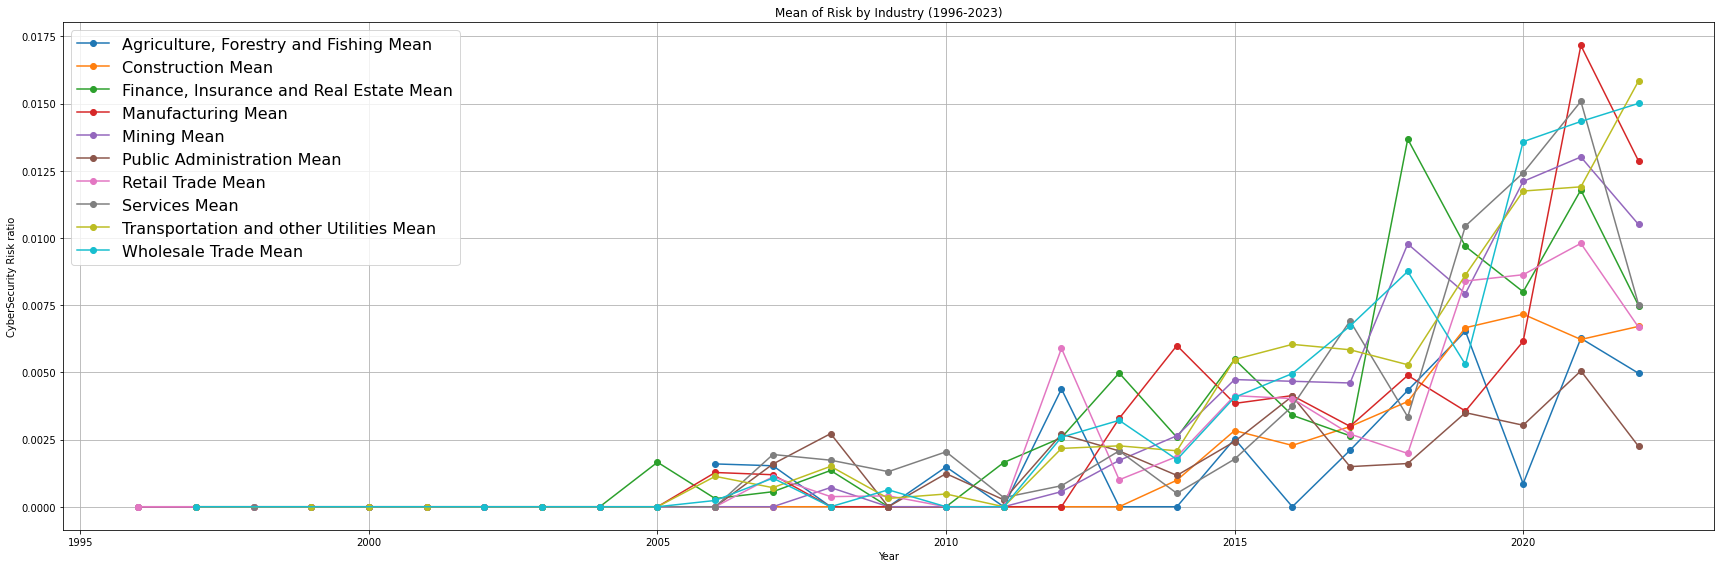

In [59]:
import matplotlib.pyplot as plt
agg_stats = merged_final.groupby(['industry', 'year'])['cybersecurity_risk_ratio'].agg(['mean', 'std']).reset_index()

agg_stats.columns = ['Industry', 'Year', 'mean_beta', 'std_beta']

plt.figure(figsize=(24, 8))

industries = agg_stats['Industry'].unique()

for industry in industries:
    industry_data = agg_stats[agg_stats['Industry'] == industry]
    
    plt.plot(industry_data['Year'], industry_data['mean_beta'], label=f'{industry} Mean', linestyle='-', marker='o')
plt.xlabel('Year')
plt.ylabel('CyberSecurity Risk ratio')
plt.title('Mean of Risk by Industry (1996-2023)')
plt.legend(loc='best', prop={'size': 16})
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


<h1> Plot of Std Dev of Cybersecurity Risk ratio across industries
    </h1>

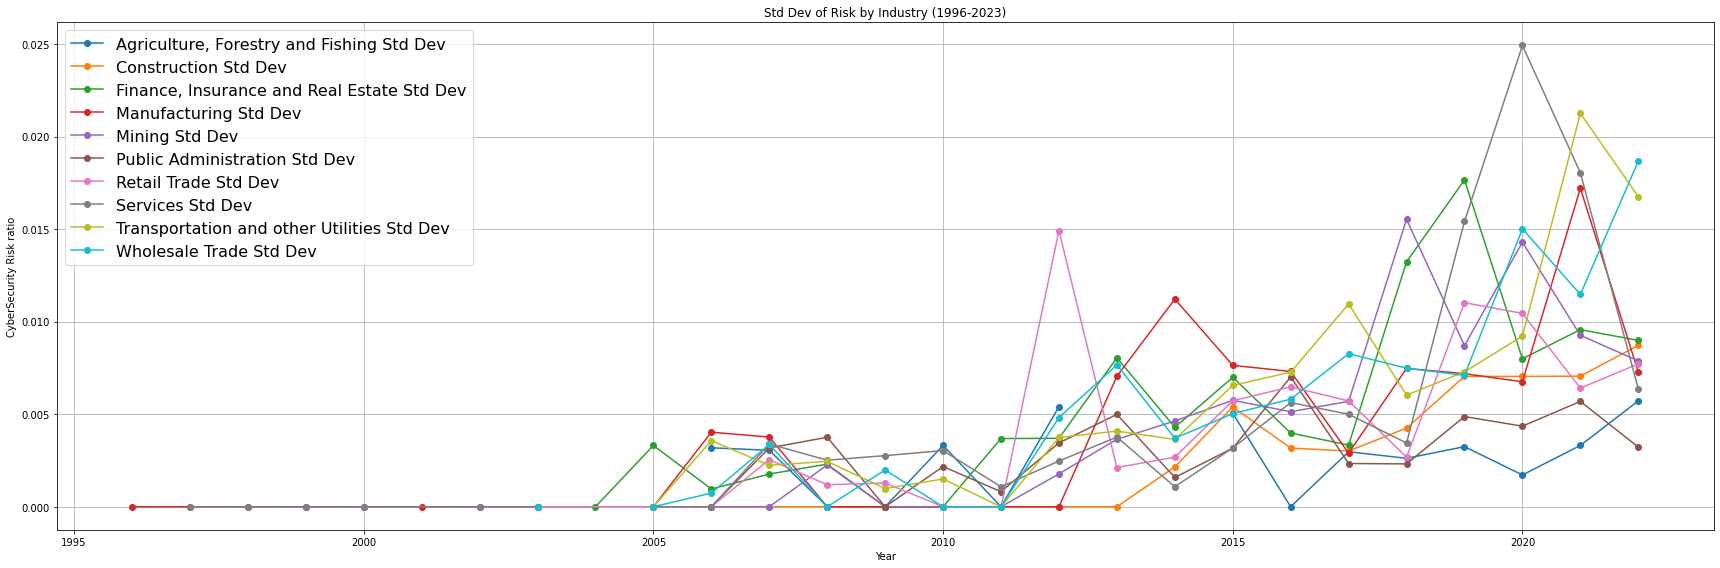

In [60]:
plt.figure(figsize=(24, 8))

industries = agg_stats['Industry'].unique()

for industry in industries:
    industry_data = agg_stats[agg_stats['Industry'] == industry]
    
    plt.plot(industry_data['Year'], industry_data['std_beta'], label=f'{industry} Std Dev', linestyle='-', marker='o')
plt.xlabel('Year')
plt.ylabel('CyberSecurity Risk ratio')
plt.title('Std Dev of Risk by Industry (1996-2023)')
plt.legend(loc='best', prop={'size': 16})
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

<h1> Plot of absolute cybersecurity risk across industries
    </h1>

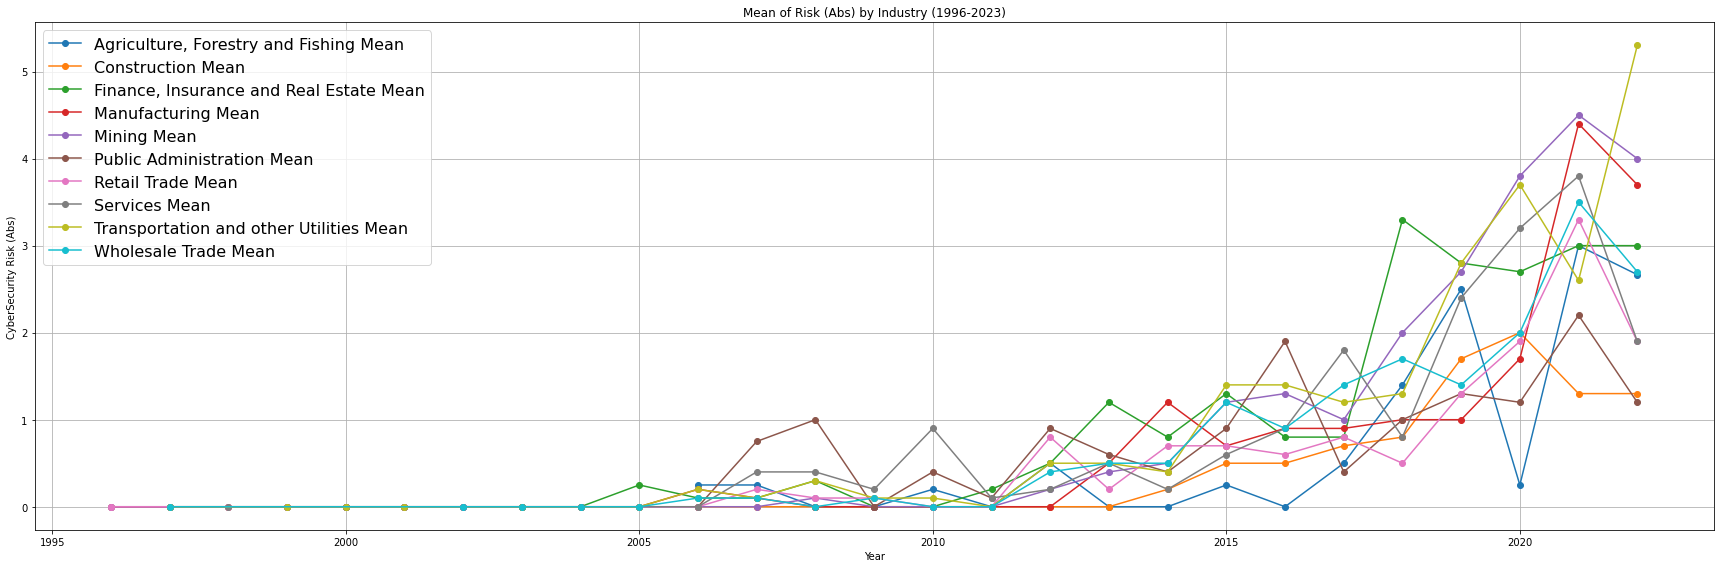

In [61]:
import matplotlib.pyplot as plt
agg_stats = merged_final.groupby(['industry', 'year'])['cybersecurity_risk_abs'].agg(['mean', 'std']).reset_index()

agg_stats.columns = ['Industry', 'Year', 'mean_beta', 'std_beta']

plt.figure(figsize=(24, 8))

industries = agg_stats['Industry'].unique()

for industry in industries:
    industry_data = agg_stats[agg_stats['Industry'] == industry]
    
    plt.plot(industry_data['Year'], industry_data['mean_beta'], label=f'{industry} Mean', linestyle='-', marker='o')
plt.xlabel('Year')
plt.ylabel('CyberSecurity Risk (Abs)')
plt.title('Mean of Risk (Abs) by Industry (1996-2023)')
plt.legend(loc='best', prop={'size': 16})
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


In [52]:
def createPortfolio(df):
    df_sorted = df.sort_values(by='cybersecurity_risk_ratio')
    df_sorted['quintile'] = pd.qcut(df_sorted['cybersecurity_risk_ratio'], 5, duplicates='drop')
    avg_beta = df_sorted.groupby('quintile')['cybersecurity_risk_ratio'].mean()
#     df_sorted['returns_excess'] = df_sorted['RET']/(100*df_sorted['MarketCap']/df_sorted['MarketCapWeight'])
    df_sorted['returns_excess'] = df_sorted['RET']
    df_sorted['return_weighted'] = df_sorted['returns_excess']*df_sorted['MarketCapWeight']/100
    avg_excess_return = df_sorted.groupby('quintile')['returns_excess'].mean()
    avg_excess_return_vw = df_sorted.groupby('quintile')['return_weighted'].mean()
#     print(avg_excess_return.values)
#     print(avg_excess_return_vw.values)
    print("Average Risk by Quintile:\n", avg_beta)
    print ("\n")
    
    print("Equal weighted Portfolio distributions:")
    difference_high_low_beta = avg_excess_return[1] - avg_excess_return[0]
    print("Average Excess Return by Quintile:\n", avg_excess_return)
    print("Difference in Excess Return (High Risk - Low Risk):", difference_high_low_beta)
    print ("\n")
    
    print("Value weighted Portfolio distributions:")
    avg_excess_return_vw = df_sorted.groupby('quintile')['return_weighted'].mean()
#     print(avg_excess_return_vw.shape)
    difference_high_low_beta_vw = avg_excess_return_vw[1] - avg_excess_return_vw[0]
    print("Average Excess Return by Quintile:\n", avg_excess_return_vw)
    print("Difference in Excess Return Value Weighted (High Risk - Low Risk):", difference_high_low_beta_vw)
                                   

<h1> Portfolio Creation - Equal Weighted and Value Weighted
    </h1>

In [53]:
createPortfolio(merged_final)

Average Risk by Quintile:
 quintile
(-0.001, 0.00587]    0.000703
(0.00587, 0.0821]    0.014784
Name: cybersecurity_risk_ratio, dtype: float64


Equal weighted Portfolio distributions:
Average Excess Return by Quintile:
 quintile
(-0.001, 0.00587]    0.018145
(0.00587, 0.0821]    0.016604
Name: returns_excess, dtype: float64
Difference in Excess Return (High Risk - Low Risk): -0.001540917201965964


Value weighted Portfolio distributions:
Average Excess Return by Quintile:
 quintile
(-0.001, 0.00587]    5.348635e-08
(0.00587, 0.0821]   -3.395542e-08
Name: return_weighted, dtype: float64
Difference in Excess Return Value Weighted (High Risk - Low Risk): -8.744177579592994e-08
